In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import datetime
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import KernelPCA
import numpy as np
import pandas as pd
import math
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
tf.random.set_seed(99)


In [42]:
dataFrame = pd.read_csv('/content/drive/My Drive/data/viettri_quality.csv', index_col='date')

In [43]:
dataFrame

,pm25,pm10,o3,no2,so2,co
date,,,,,,
3/1/2019,44,17,29,2,9,4
3/2/2019,65,37,27,4,12,4
3/3/2019,81,38,2,1,1,2
3/4/2019,51,24,21,4,8,1
3/5/2019,43,7,23,1,12,4
...,...,...,...,...,...,...
5/28/2024,38,24,35,1,15,5
5/29/2024,38,17,41,7,15,10
5/30/2024,28,8,11,1,15,1


In [44]:
imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0) # Handling missing values, fill with 0 instead of removing
dataFrame = pd.DataFrame(imputer.fit_transform(dataFrame), columns=dataFrame.columns)
dataFrame = dataFrame.reset_index(drop=True)
# Applying feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(dataFrame.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=list(dataFrame.columns))
target_scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled[['pm25']] = target_scaler.fit_transform(dataFrame[['pm25']].to_numpy())
df_scaled = df_scaled.astype(float)

In [45]:
# Single step dataset preparation
def singleStepSampler(df, window):
	xRes = []
	yRes = []
	for i in range(0, len(df) - window):
		res = []
		for j in range(0, window):
			r = []
			for col in df.columns:
				r.append(df[col][i + j])
			res.append(r)
		xRes.append(res)
		yRes.append(df[['pm25']].iloc[i + window].values)
	return np.array(xRes), np.array(yRes)


In [46]:
# Dataset splitting
SPLIT = 0.7
(xVal, yVal) = singleStepSampler(df_scaled, 20)
X_train = xVal[:int(SPLIT * len(xVal))]
y_train = yVal[:int(SPLIT * len(yVal))]
X_test = xVal[int(SPLIT * len(xVal)):]
y_test = yVal[int(SPLIT * len(yVal)):]

In [47]:
n_forecast = 5

In [48]:
model_gru = keras.Sequential()
model_gru.add(keras.layers.GRU(30, input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(keras.layers.Dropout(0.2))
model_gru.add(keras.layers.Dense(n_forecast, activation='linear'))
model_gru.compile(loss = 'MeanSquaredError', metrics=['MAE'], optimizer='Adam')
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 30)                3420      
                                                                 
 dropout_2 (Dropout)         (None, 30)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 155       
                                                                 
Total params: 3575 (13.96 KB)
Trainable params: 3575 (13.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [49]:
history = model_gru.fit(X_train, y_train, epochs=20)

Epoch 1/20
42/42 [==============================] - 2s 10ms/step - loss: 0.0473 - MAE: 0.1584
Epoch 2/20
42/42 [==============================] - 0s 10ms/step - loss: 0.0281 - MAE: 0.1243
Epoch 3/20
42/42 [==============================] - 0s 10ms/step - loss: 0.0246 - MAE: 0.1138
Epoch 4/20
42/42 [==============================] - 0s 10ms/step - loss: 0.0230 - MAE: 0.1065
Epoch 5/20
42/42 [==============================] - 0s 10ms/step - loss: 0.0220 - MAE: 0.1028
Epoch 6/20
42/42 [==============================] - 0s 10ms/step - loss: 0.0211 - MAE: 0.1009
Epoch 7/20
42/42 [==============================] - 0s 10ms/step - loss: 0.0211 - MAE: 0.0997
Epoch 8/20
42/42 [==============================] - 0s 10ms/step - loss: 0.0201 - MAE: 0.0968
Epoch 9/20
42/42 [==============================] - 0s 10ms/step - loss: 0.0203 - MAE: 0.0964
Epoch 10/20
42/42 [==============================] - 0s 10ms/step - loss: 0.0202 - MAE: 0.0951
Epoch 11/20
42/42 [==============================] - 0s 10m

In [50]:
# Reload the data with the date index
dataFrame = pd.read_csv('/content/drive/My Drive/data/hanoi_quality.csv') # Assuming the CSV file contains a 'Date' column
dataFrame['date'] = pd.to_datetime(dataFrame['date'])
dataFrame.set_index('date', inplace=True)

# Forecast Plot with Dates on X-axis
predicted_values = model_gru.predict(X_test)

d = {
	'Predicted_pm25': predicted_values[:, 0],
 'Actual_pm25': y_test[:, 0],
}

d = pd.DataFrame(d)
d.index = dataFrame.index[-len(y_test):] # Assigning the correct date index


18/18 [==============================] - 1s 5ms/step


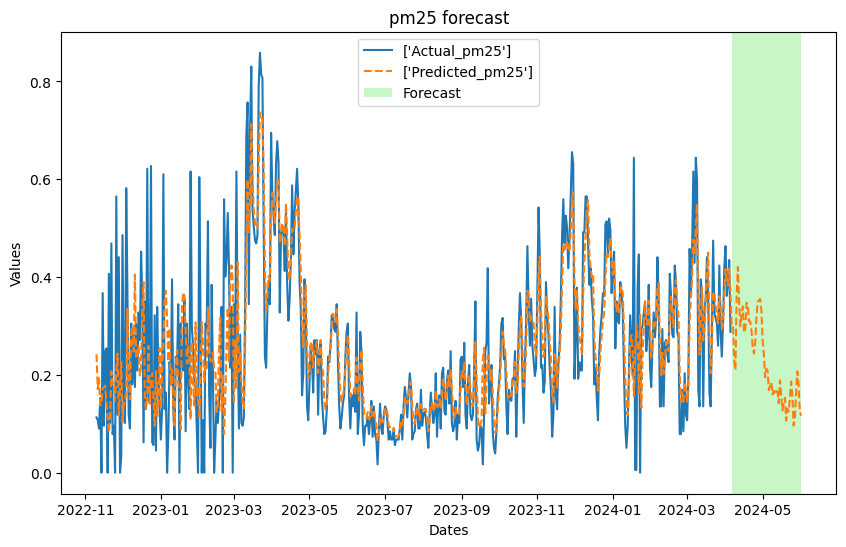

In [51]:
fig, ax = plt.subplots(figsize=(10, 6))
# highlight the forecast
highlight_start = int(len(d) * 0.9)
highlight_end = len(d) - 1 # Adjusted to stay within bounds
# Plot the actual values
plt.plot(d[['Actual_pm25']][:highlight_start], label=['Actual_pm25'])

# Plot predicted values with a dashed line
plt.plot(d[['Predicted_pm25']], label=['Predicted_pm25'], linestyle='--')

# Highlight the forecasted portion with a different color
plt.axvspan(d.index[highlight_start], d.index[highlight_end], facecolor='lightgreen', alpha=0.5, label='Forecast')

plt.title('pm25 forecast')
plt.xlabel('Dates')
plt.ylabel('Values')
ax.legend()
plt.show()

In [52]:
predicted_values

array([[0.24205247, 0.24621364, 0.23273505, 0.2360971 , 0.24521019],
       [0.17099407, 0.18012506, 0.17404942, 0.1765869 , 0.17725956],
       [0.19330004, 0.1888619 , 0.19290416, 0.19126877, 0.19359633],
       ...,
       [0.18142045, 0.17020485, 0.17137562, 0.17863475, 0.16616915],
       [0.12604634, 0.10628673, 0.10268056, 0.08866642, 0.10468686],
       [0.11666279, 0.10489307, 0.10213462, 0.09572875, 0.10244959]],
      dtype=float32)

In [53]:
predicted_values_90 = predicted_values[:18]

In [54]:
pm25_scaler = target_scaler
# Perform the inverse transformation on the scaled pm25 data
predicted_values_90 = pm25_scaler.inverse_transform(predicted_values_90)

# Check the DataFrame to see the reversed pm25 values
print(predicted_values_90)

[[43.843285 44.579815 42.194103 42.789185 44.402206]
 [31.265951 32.882133 31.806747 32.25588  32.374943]
 [35.214108 34.42856  35.144035 34.854572 35.266552]
 [25.39185  22.268654 22.449696 22.443197 22.757706]
 [25.981628 25.959421 26.49064  25.262352 24.671406]
 [31.689465 31.503057 29.922827 29.685411 30.024038]
 [31.876312 29.60757  29.614264 28.058945 27.044106]
 [32.488304 32.471706 31.648695 30.827934 29.708187]
 [26.336622 27.49299  27.121923 27.491482 25.17928 ]
 [20.68991  19.681406 20.478935 19.496246 18.347412]
 [15.419306 16.761684 15.5071   16.3596   15.999033]
 [22.460533 21.266872 20.991814 21.097816 20.530533]
 [37.695747 39.20337  38.055008 37.38593  37.39477 ]
 [33.12618  30.063818 30.112246 28.654943 27.630049]
 [33.540928 39.43766  35.139854 38.083733 37.721535]
 [27.063211 27.592873 24.259459 26.838951 28.370903]
 [37.521725 39.697712 36.791336 37.711662 39.366894]
 [44.098305 39.839497 40.107464 37.983055 38.177242]]


In [55]:
predicted_values_90 = np.concatenate(predicted_values_90, axis=0)

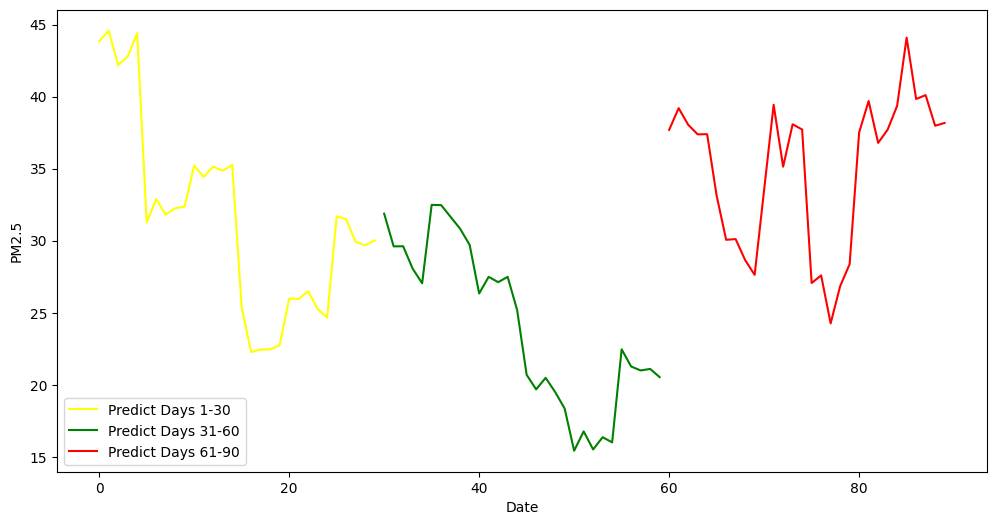

In [56]:
plt.figure(figsize=(12, 6))

dates = np.arange(1, 91)
data = pd.DataFrame({'Date': dates, 'predicted_values_90': predicted_values_90})

plt.plot(data['predicted_values_90'][:30], color='yellow', label='Predict Days 1-30')
plt.plot(data['predicted_values_90'][30:60], color='green', label='Predict Days 31-60')
plt.plot(data['predicted_values_90'][60:], color='red', label='Predict Days 61-90')

# Adding labels and legend
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.legend()

# Show plot
plt.show()

In [57]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
if predicted_values.ndim == 1:
    predicted_values = predicted_values.reshape(-1, 1)

# Inverse transform the predicted values
predicted_values_all = pm25_scaler.inverse_transform(predicted_values)

# Check the shape after inverse transformation
print("Shape of y_test:", y_test.shape)
print("Shape of predicted_values_all:", predicted_values_all.shape)
# Aggregate predictions to match the shape of y_test
predicted_values_aggregated = np.mean(predicted_values_all, axis=1, keepdims=True)

# Calculate the RMSE, MAE, and MAPE
rmse = mean_squared_error(y_test, predicted_values_aggregated, squared=False)
mae = mean_absolute_error(y_test, predicted_values_aggregated)
mape = mean_absolute_percentage_error(y_test, predicted_values_aggregated)

# Print the results
print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE:", mape)


Shape of y_test: (570, 1)
Shape of predicted_values_all: (570, 5)
RMSE: 50.17646431261406
MAE: 45.15080624670278
MAPE: 4030134503778306.5
